# EEG Person Identification - Part 1: Data Preprocessing

## Overview
This notebook handles:
1. Loading PhysioNet Motor Movement/Imagery Dataset
2. Preprocessing EEG signals (filtering, artifact removal)
3. Segmenting data into epochs
4. Creating time-frequency representations (spectrograms)
5. Preparing data for CNN+RNN model

**Dataset**: 109 subjects, 2 sessions each, motor imagery tasks

In [14]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# EEG Processing
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

# Signal Processing
from scipy import signal
from scipy.signal import stft

# Data Management
import pickle
import h5py

# Set random seeds for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries imported successfully!")
print(f"MNE version: {mne.__version__}")

Libraries imported successfully!
MNE version: 1.10.2


## 1. Configuration and Setup

In [15]:
# Configuration parameters
CONFIG = {
    # Data parameters
    'n_subjects': 109,  # Total subjects in PhysioNet dataset
    'runs': [3, 7, 11],  # Motor imagery runs (left hand, right hand, both hands/feet)
    'n_subjects_to_use': 109,  # Use all subjects (can reduce for faster testing)
    
    # Preprocessing parameters
    'sfreq': 160,  # Sampling frequency in Hz
    'l_freq': 0.5,  # Low-pass filter cutoff
    'h_freq': 50.0,  # High-pass filter cutoff
    'epoch_duration': 3.0,  # Duration of each epoch in seconds
    'overlap': 0.5,  # Overlap ratio between consecutive epochs
    
    # Time-frequency parameters
    'n_fft': 256,  # FFT window size for STFT
    'hop_length': 32,  # Hop length for STFT
    'n_freq_bins': 50,  # Number of frequency bins to keep
    
    # Data split parameters
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    
    # Output paths
    'data_dir': 'data',
    'processed_dir': 'data/processed',
    'figures_dir': 'figures'
}

# Create directories
for directory in [CONFIG['data_dir'], CONFIG['processed_dir'], CONFIG['figures_dir']]:
    os.makedirs(directory, exist_ok=True)

print("Configuration set!")
print(f"\nPreprocessing Settings:")
print(f"  - Subjects: {CONFIG['n_subjects_to_use']}")
print(f"  - Sampling Rate: {CONFIG['sfreq']} Hz")
print(f"  - Bandpass Filter: {CONFIG['l_freq']}-{CONFIG['h_freq']} Hz")
print(f"  - Epoch Duration: {CONFIG['epoch_duration']} seconds")
print(f"  - Overlap: {CONFIG['overlap']*100}%")

Configuration set!

Preprocessing Settings:
  - Subjects: 109
  - Sampling Rate: 160 Hz
  - Bandpass Filter: 0.5-50.0 Hz
  - Epoch Duration: 3.0 seconds
  - Overlap: 50.0%


## 2. Data Loading

Download and load EEG data from PhysioNet Motor Movement/Imagery Database.
- 64-channel EEG recordings
- Motor imagery tasks (left hand, right hand, both hands, both feet)

In [16]:
def load_subject_data(subject_id, runs, verbose=False):
    """
    Load EEG data for a single subject.
    
    Parameters:
    -----------
    subject_id : int
        Subject ID (1-109)
    runs : list
        List of run numbers to load
    verbose : bool
        Print loading information
        
    Returns:
    --------
    raw : mne.io.Raw
        Concatenated raw EEG data
    """
    # Load the specified runs for this subject
    raw_fnames = eegbci.load_data(subject_id, runs, verbose=verbose)
    
    # Read and concatenate all runs
    raw_list = [read_raw_edf(f, preload=True, verbose=verbose) for f in raw_fnames]
    raw = concatenate_raws(raw_list)
    
    # Standardize channel names
    eegbci.standardize(raw)
    
    # Set montage (electrode positions)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage, on_missing='ignore')
    
    return raw

# Test loading one subject
print("Testing data loading with Subject 1...")
test_raw = load_subject_data(1, CONFIG['runs'], verbose=False)
print(f"\nLoaded successfully!")
print(f"  - Channels: {len(test_raw.ch_names)}")
print(f"  - Sampling Rate: {test_raw.info['sfreq']} Hz")
print(f"  - Duration: {test_raw.times[-1]:.2f} seconds")
print(f"  - Channel names: {test_raw.ch_names[:5]}...")

Testing data loading with Subject 1...

Loaded successfully!
  - Channels: 64
  - Sampling Rate: 160.0 Hz
  - Duration: 374.99 seconds
  - Channel names: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2']...


## 3. Visualize Raw EEG Data

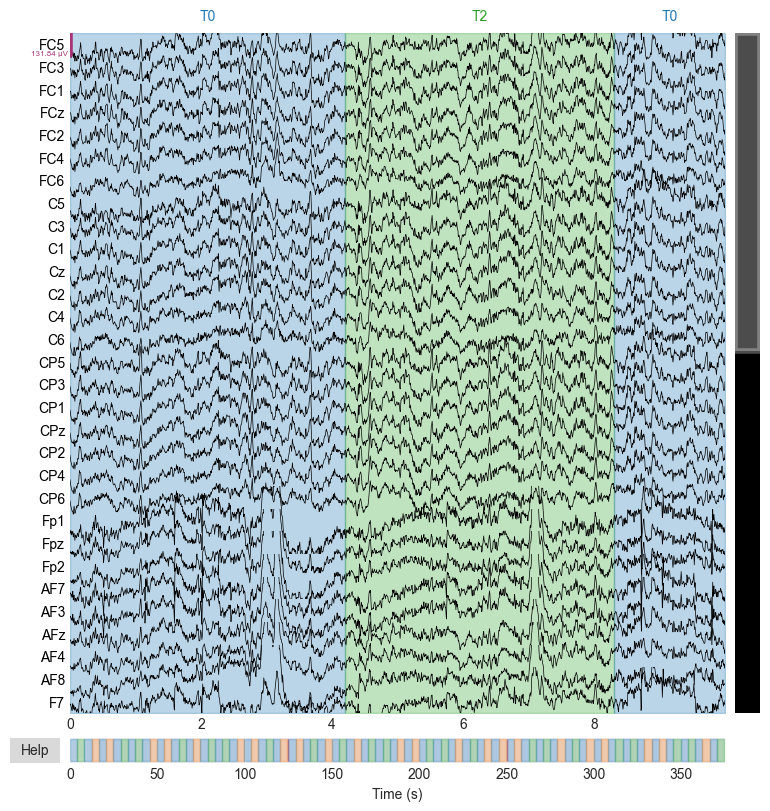

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


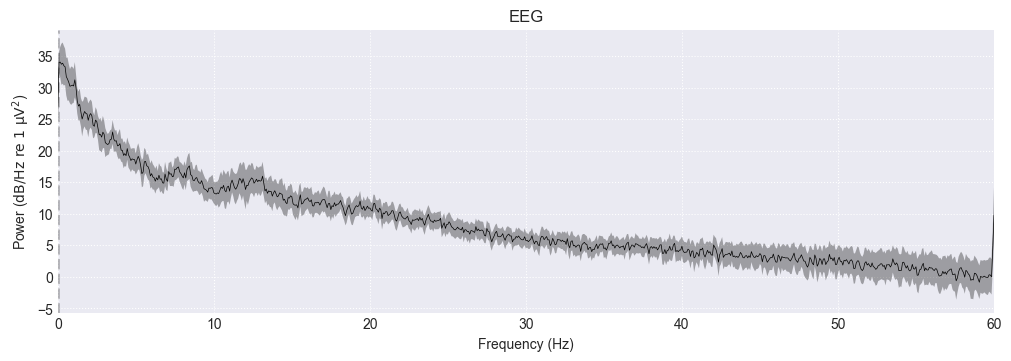

Raw EEG visualizations saved!


In [17]:
# Plot a 10-second segment of raw EEG
fig = test_raw.plot(duration=10, n_channels=30, scalings='auto', 
                     title='Raw EEG Signal (Subject 1)', show=False)
plt.savefig(os.path.join(CONFIG['figures_dir'], 'raw_eeg_sample.png'), dpi=150, bbox_inches='tight')
plt.show()

# Plot power spectral density
fig = test_raw.plot_psd(fmax=60, average=True, show=False)
plt.savefig(os.path.join(CONFIG['figures_dir'], 'psd_raw.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Raw EEG visualizations saved!")

## 4. Preprocessing Pipeline

Apply bandpass filtering and artifact removal to clean the EEG signals.

Testing preprocessing...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


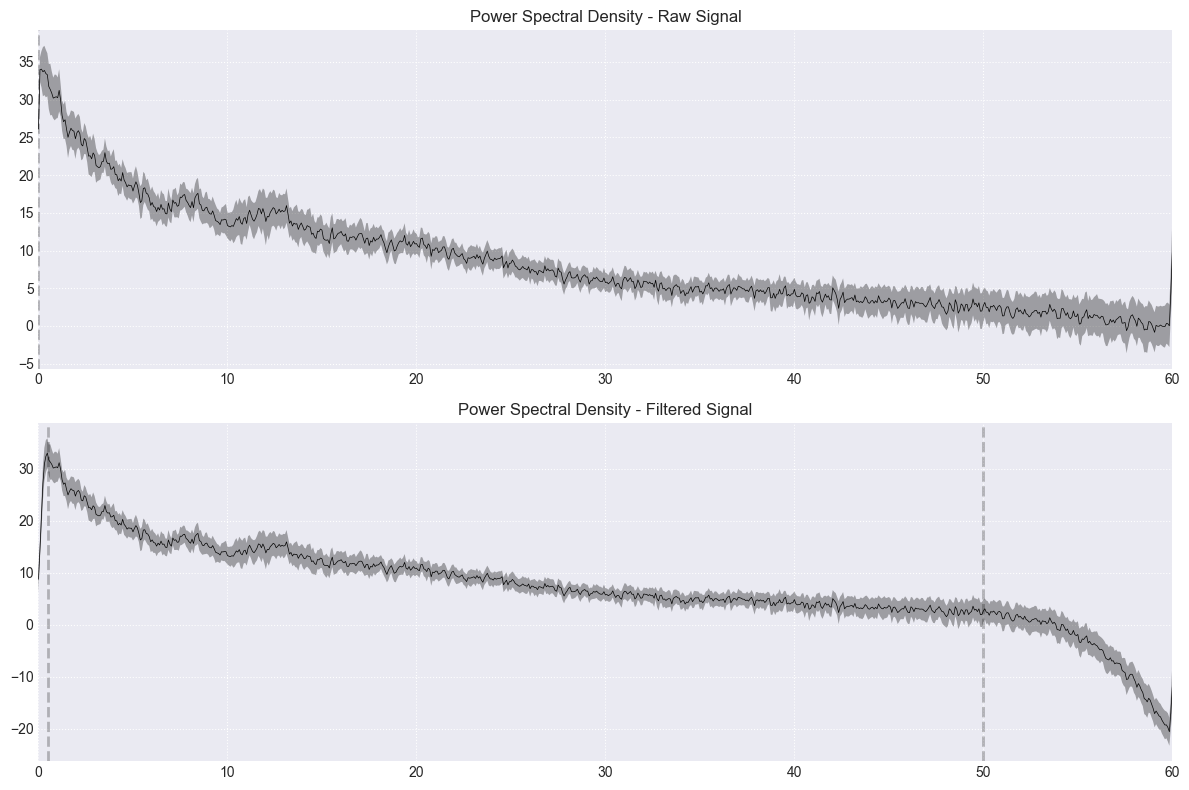

Preprocessing validated!


In [18]:
def preprocess_raw(raw, l_freq=0.5, h_freq=50.0):
    """
    Apply preprocessing to raw EEG data.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG data
    l_freq : float
        Low-pass filter cutoff
    h_freq : float
        High-pass filter cutoff
        
    Returns:
    --------
    raw_filtered : mne.io.Raw
        Preprocessed EEG data
    """
    # Create a copy to avoid modifying original
    raw_filtered = raw.copy()
    
    # Apply bandpass filter
    raw_filtered.filter(l_freq, h_freq, fir_design='firwin', verbose=False)
    
    # Remove EOG artifacts if EOG channels exist
    # For this dataset, we'll use ICA-based artifact removal (optional)
    
    return raw_filtered

# Test preprocessing
print("Testing preprocessing...")
test_filtered = preprocess_raw(test_raw, CONFIG['l_freq'], CONFIG['h_freq'])

# Compare raw vs filtered
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot raw signal
test_raw.plot_psd(fmax=60, average=True, ax=axes[0], show=False)
axes[0].set_title('Power Spectral Density - Raw Signal')

# Plot filtered signal
test_filtered.plot_psd(fmax=60, average=True, ax=axes[1], show=False)
axes[1].set_title('Power Spectral Density - Filtered Signal')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['figures_dir'], 'preprocessing_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Preprocessing validated!")

## 5. Epoch Segmentation

Divide continuous EEG into fixed-duration epochs with overlap.

In [19]:
def create_epochs(raw, epoch_duration=3.0, overlap=0.5):
    """
    Create fixed-duration epochs from continuous EEG data.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Preprocessed EEG data
    epoch_duration : float
        Duration of each epoch in seconds
    overlap : float
        Overlap ratio (0-1)
        
    Returns:
    --------
    epochs_data : np.ndarray
        Array of shape (n_epochs, n_channels, n_times)
    """
    # Get data as numpy array
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    
    # Calculate epoch parameters
    n_samples_per_epoch = int(epoch_duration * sfreq)
    step_size = int(n_samples_per_epoch * (1 - overlap))
    
    # Create epochs with sliding window
    epochs_list = []
    n_channels, n_samples = data.shape
    
    for start_idx in range(0, n_samples - n_samples_per_epoch + 1, step_size):
        end_idx = start_idx + n_samples_per_epoch
        epoch = data[:, start_idx:end_idx]
        epochs_list.append(epoch)
    
    epochs_data = np.array(epochs_list)
    return epochs_data

# Test epoch creation
print("Creating epochs...")
test_epochs = create_epochs(test_filtered, CONFIG['epoch_duration'], CONFIG['overlap'])
print(f"Epochs shape: {test_epochs.shape}")
print(f"  - Number of epochs: {test_epochs.shape[0]}")
print(f"  - Channels: {test_epochs.shape[1]}")
print(f"  - Time samples per epoch: {test_epochs.shape[2]}")

Creating epochs...
Epochs shape: (249, 64, 480)
  - Number of epochs: 249
  - Channels: 64
  - Time samples per epoch: 480


## 6. Time-Frequency Representation (Spectrograms)

Convert epochs to spectrograms using Short-Time Fourier Transform (STFT).

In [20]:
def compute_spectrograms(epochs_data, sfreq, n_fft=256, hop_length=32, n_freq_bins=50, expected_time_bins=None):
    """
    Compute spectrograms for all epochs and channels.
    
    Parameters:
    -----------
    epochs_data : np.ndarray
        Array of shape (n_epochs, n_channels, n_times)
    sfreq : float
        Sampling frequency
    n_fft : int
        FFT window size
    hop_length : int
        Hop length for STFT
    n_freq_bins : int
        Number of frequency bins to keep
    expected_time_bins : int, optional
        Expected number of time bins. If None, will be computed from first epoch.
        
    Returns:
    --------
    spectrograms : np.ndarray
        Array of shape (n_epochs, n_channels, n_freq_bins, n_time_bins)
    """
    n_epochs, n_channels, n_times = epochs_data.shape
    spectrograms_list = []
    
    # Determine expected time dimension
    if expected_time_bins is None:
        # Compute from first epoch
        f, t, Zxx = stft(epochs_data[0, 0], fs=sfreq, nperseg=n_fft, 
                        noverlap=n_fft-hop_length)
        expected_time_bins = Zxx.shape[1]
    
    for epoch in tqdm(epochs_data, desc="Computing spectrograms", leave=False):
        epoch_spectrograms = []
        
        for channel_data in epoch:
            # Compute STFT
            f, t, Zxx = stft(channel_data, fs=sfreq, nperseg=n_fft, 
                            noverlap=n_fft-hop_length)
            
            # Convert to magnitude and take log
            magnitude = np.abs(Zxx)
            log_magnitude = np.log1p(magnitude)  # log(1 + x) for stability
            
            # Keep only first n_freq_bins
            log_magnitude = log_magnitude[:n_freq_bins, :]
            
            # Ensure consistent time dimension by padding or truncating
            current_time_bins = log_magnitude.shape[1]
            if current_time_bins < expected_time_bins:
                # Pad with edge values if too short
                pad_width = expected_time_bins - current_time_bins
                log_magnitude = np.pad(log_magnitude, ((0, 0), (0, pad_width)), mode='edge')
            elif current_time_bins > expected_time_bins:
                # Truncate if too long
                log_magnitude = log_magnitude[:, :expected_time_bins]
            
            epoch_spectrograms.append(log_magnitude)
        
        spectrograms_list.append(np.array(epoch_spectrograms))
    
    spectrograms = np.array(spectrograms_list)
    return spectrograms

# Test spectrogram computation
print("\nComputing spectrograms for test subject...")
test_spectrograms = compute_spectrograms(
    test_epochs, 
    test_filtered.info['sfreq'],
    CONFIG['n_fft'],
    CONFIG['hop_length'],
    CONFIG['n_freq_bins']
)
print(f"\nSpectrograms shape: {test_spectrograms.shape}")
print(f"  - Number of epochs: {test_spectrograms.shape[0]}")
print(f"  - Channels: {test_spectrograms.shape[1]}")
print(f"  - Frequency bins: {test_spectrograms.shape[2]}")
print(f"  - Time bins: {test_spectrograms.shape[3]}")

# Store the expected time bins for use in process_all_subjects
CONFIG['expected_time_bins'] = test_spectrograms.shape[3]
print(f"\nExpected time bins set to: {CONFIG['expected_time_bins']}")


Computing spectrograms for test subject...



Spectrograms shape: (249, 64, 50, 16)
  - Number of epochs: 249
  - Channels: 64
  - Frequency bins: 50
  - Time bins: 16

Expected time bins set to: 16


## 7. Visualize Spectrograms

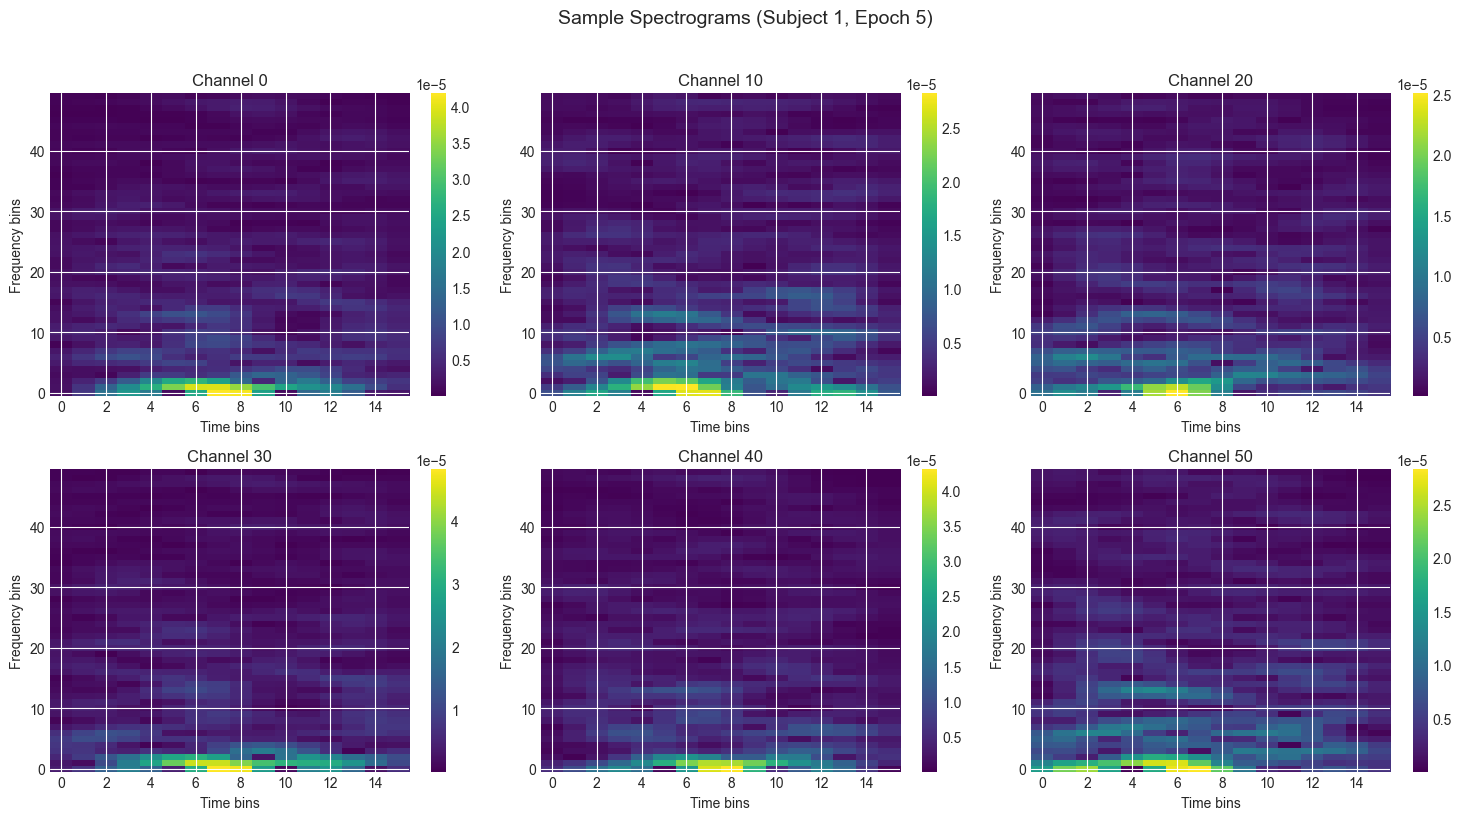

Spectrogram visualizations saved!


In [21]:
# Visualize spectrograms for a few channels
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

channels_to_plot = [0, 10, 20, 30, 40, 50]  # Sample different channels
epoch_idx = 5  # Pick an epoch

for idx, ch_idx in enumerate(channels_to_plot):
    im = axes[idx].imshow(test_spectrograms[epoch_idx, ch_idx], 
                          aspect='auto', origin='lower', cmap='viridis')
    axes[idx].set_title(f'Channel {ch_idx}')
    axes[idx].set_xlabel('Time bins')
    axes[idx].set_ylabel('Frequency bins')
    plt.colorbar(im, ax=axes[idx])

plt.suptitle('Sample Spectrograms (Subject 1, Epoch 5)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['figures_dir'], 'sample_spectrograms.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Spectrogram visualizations saved!")

## 8. Process All Subjects

Load and preprocess data for all subjects in the dataset.

In [22]:
def process_all_subjects(n_subjects, config):
    """
    Process all subjects and create spectrograms.
    
    Returns:
    --------
    X : np.ndarray
        Spectrograms for all subjects
    y : np.ndarray
        Subject labels (0 to n_subjects-1)
    """
    all_spectrograms = []
    all_labels = []
    
    # Get the expected time bins from config (set during initial testing)
    expected_time_bins = config.get('expected_time_bins', None)
    
    print(f"Processing {n_subjects} subjects...")
    if expected_time_bins is not None:
        print(f"Using fixed time bins: {expected_time_bins}\n")
    
    for subject_id in tqdm(range(1, n_subjects + 1), desc="Subjects"):
        try:
            # Load subject data
            raw = load_subject_data(subject_id, config['runs'], verbose=False)
            
            # Preprocess
            raw_filtered = preprocess_raw(raw, config['l_freq'], config['h_freq'])
            
            # Create epochs
            epochs = create_epochs(raw_filtered, config['epoch_duration'], config['overlap'])
            
            # Compute spectrograms with fixed time bins
            spectrograms = compute_spectrograms(
                epochs,
                raw_filtered.info['sfreq'],
                config['n_fft'],
                config['hop_length'],
                config['n_freq_bins'],
                expected_time_bins=expected_time_bins  # Pass the fixed time bins
            )
            
            # Normalize spectrograms per subject (z-score)
            mean = spectrograms.mean()
            std = spectrograms.std()
            spectrograms = (spectrograms - mean) / (std + 1e-8)
            
            # Store data
            all_spectrograms.append(spectrograms)
            all_labels.extend([subject_id - 1] * len(spectrograms))  # 0-indexed labels
            
        except Exception as e:
            print(f"\nError processing subject {subject_id}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Concatenate all data
    print(f"\nConcatenating data from {len(all_spectrograms)} subjects...")
    
    # Debug: Print shapes before concatenation
    print("Sample shapes:")
    for i in range(min(5, len(all_spectrograms))):
        print(f"  Subject {i+1}: {all_spectrograms[i].shape}")
    
    X = np.concatenate(all_spectrograms, axis=0)
    y = np.array(all_labels)
    
    print(f"\nProcessing complete!")
    print(f"Total samples: {len(X)}")
    print(f"Shape: {X.shape}")
    
    return X, y

# Process all subjects
print("Starting full dataset processing...")
print(f"This may take 30-60 minutes depending on your hardware.\n")

X_all, y_all = process_all_subjects(CONFIG['n_subjects_to_use'], CONFIG)

print(f"\nFinal dataset:")
print(f"  X shape: {X_all.shape}")
print(f"  y shape: {y_all.shape}")
print(f"  Unique subjects: {len(np.unique(y_all))}")
print(f"  Samples per subject (avg): {len(y_all) / len(np.unique(y_all)):.1f}")

Starting full dataset processing...
This may take 30-60 minutes depending on your hardware.

Processing 109 subjects...
Using fixed time bins: 16



Subjects: 100%|██████████| 109/109 [08:51<00:00,  4.88s/it]



Concatenating data from 109 subjects...
Sample shapes:
  Subject 1: (249, 64, 50, 16)
  Subject 2: (245, 64, 50, 16)
  Subject 3: (249, 64, 50, 16)
  Subject 4: (245, 64, 50, 16)
  Subject 5: (245, 64, 50, 16)

Processing complete!
Total samples: 26839
Shape: (26839, 64, 50, 16)

Final dataset:
  X shape: (26839, 64, 50, 16)
  y shape: (26839,)
  Unique subjects: 109
  Samples per subject (avg): 246.2


## 9. Data Distribution Analysis

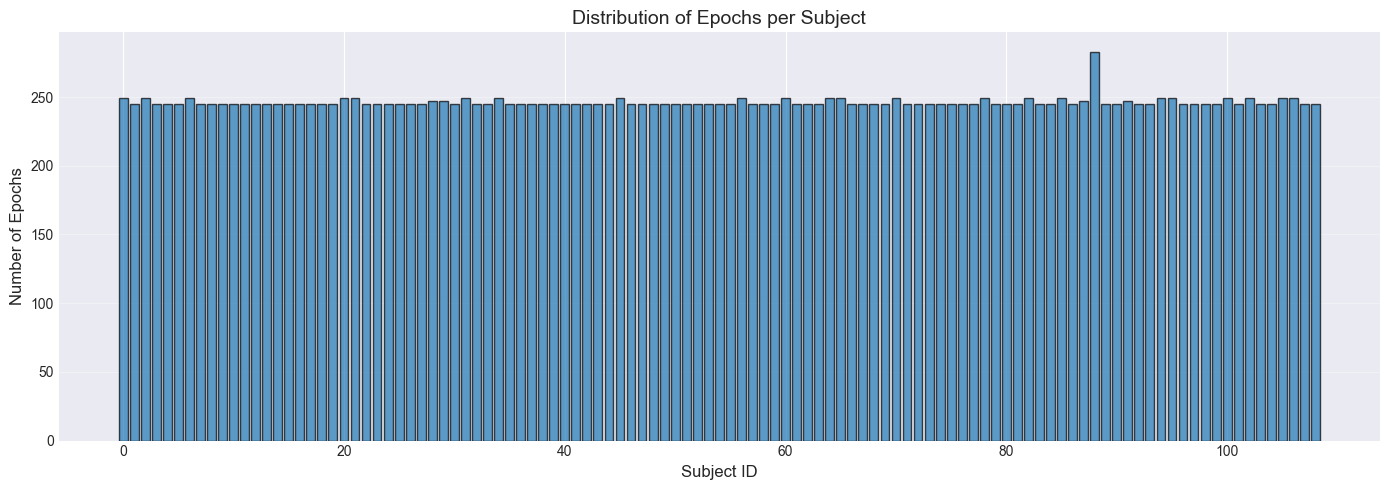

Statistics:
  Mean epochs per subject: 246.2
  Std epochs per subject: 3.9
  Min epochs: 245
  Max epochs: 283


In [23]:
# Analyze class distribution
unique_subjects, counts = np.unique(y_all, return_counts=True)

plt.figure(figsize=(14, 5))
plt.bar(unique_subjects, counts, alpha=0.7, edgecolor='black')
plt.xlabel('Subject ID', fontsize=12)
plt.ylabel('Number of Epochs', fontsize=12)
plt.title('Distribution of Epochs per Subject', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['figures_dir'], 'class_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Statistics:")
print(f"  Mean epochs per subject: {counts.mean():.1f}")
print(f"  Std epochs per subject: {counts.std():.1f}")
print(f"  Min epochs: {counts.min()}")
print(f"  Max epochs: {counts.max()}")

## 10. Train/Validation/Test Split

Split data ensuring each subject appears in all sets.

In [24]:
from sklearn.model_selection import train_test_split

def stratified_split(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split data with stratification to ensure all subjects in all sets.
    """
    # First split: train and temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, train_size=train_ratio, stratify=y, random_state=random_state
    )
    
    # Second split: val and test
    val_size = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, train_size=val_size, stratify=y_temp, random_state=random_state
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Perform split
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split(
    X_all, y_all,
    CONFIG['train_ratio'],
    CONFIG['val_ratio'],
    CONFIG['test_ratio']
)

print("Data split complete!\n")
print(f"Training set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Unique subjects: {len(np.unique(y_train))}")

print(f"\nValidation set:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  Unique subjects: {len(np.unique(y_val))}")

print(f"\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Unique subjects: {len(np.unique(y_test))}")

Data split complete!

Training set:
  X_train: (18787, 64, 50, 16)
  y_train: (18787,)
  Unique subjects: 109

Validation set:
  X_val: (4026, 64, 50, 16)
  y_val: (4026,)
  Unique subjects: 109

Test set:
  X_test: (4026, 64, 50, 16)
  y_test: (4026,)
  Unique subjects: 109


## 11. Save Preprocessed Data

Save all preprocessed data for model training.

In [25]:
# Save using HDF5 for efficient storage
output_file = os.path.join(CONFIG['processed_dir'], 'preprocessed_data.h5')

with h5py.File(output_file, 'w') as f:
    # Training data
    f.create_dataset('X_train', data=X_train, compression='gzip')
    f.create_dataset('y_train', data=y_train, compression='gzip')
    
    # Validation data
    f.create_dataset('X_val', data=X_val, compression='gzip')
    f.create_dataset('y_val', data=y_val, compression='gzip')
    
    # Test data
    f.create_dataset('X_test', data=X_test, compression='gzip')
    f.create_dataset('y_test', data=y_test, compression='gzip')
    
    # Save configuration
    f.attrs['n_subjects'] = CONFIG['n_subjects_to_use']
    f.attrs['n_channels'] = X_train.shape[1]
    f.attrs['n_freq_bins'] = X_train.shape[2]
    f.attrs['n_time_bins'] = X_train.shape[3]
    f.attrs['epoch_duration'] = CONFIG['epoch_duration']
    f.attrs['sfreq'] = CONFIG['sfreq']

print(f"\nData saved successfully to: {output_file}")
print(f"File size: {os.path.getsize(output_file) / (1024**2):.2f} MB")

# Also save config as pickle for reference
config_file = os.path.join(CONFIG['processed_dir'], 'config.pkl')
with open(config_file, 'wb') as f:
    pickle.dump(CONFIG, f)

print(f"Configuration saved to: {config_file}")


Data saved successfully to: data/processed\preprocessed_data.h5
File size: 9980.35 MB
Configuration saved to: data/processed\config.pkl


## Summary

### Preprocessing Complete!

**What we did:**
1. Loaded EEG data from 109 subjects (PhysioNet dataset)
2. Applied bandpass filtering (0.5-50 Hz)
3. Segmented into 3-second epochs with 50% overlap
4. Computed time-frequency spectrograms using STFT
5. Normalized and split data (70% train, 15% val, 15% test)
6. Saved preprocessed data for model training

**Data shape:**
- Input: (n_epochs, n_channels, n_freq_bins, n_time_bins)
- Each sample is a multi-channel spectrogram
- Ready for CNN feature extraction

**Next steps:**
- Proceed to `2_model_training.ipynb` to build and train the CNN+RNN model
- The model will learn to identify subjects based on their unique EEG patterns